In [2]:
%matplotlib inline
import os, h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import healpy as hp
from icecream import ic

from msfm.utils import tfrecords, cosmogrid
from msfm.utils.input_output import read_yaml

In [3]:
def get_dataset(tfr_dirs, batch_size):
    dataset = tf.data.TFRecordDataset(tfr_dirs)
    dataset = dataset.map(
        tfrecords.parse_inverse_fiducial, num_parallel_calls=1, deterministic=True
    )
#     dataset = dataset.batch(batch_size, drop_remainder=False)

    return dataset

In [4]:
tfr_dir = "/cluster/scratch/athomsen/CosmoGrid/DESY3/v1/fiducial"
tfr_file = "DESy3_fiducial_patches_000.tfrecord"

tfr_dirs = [os.path.join(tfr_dir, tfr_file)]

dataset = get_dataset(tfr_dirs, batch_size=1)

In [5]:
for kg, ia, sn in dataset.take(1):
    print(kg.shape)

(13, 463872, 4)


# plotting

In [6]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

pix_file = "../../data/DESY3_pixels_512.h5"
with h5py.File(pix_file, "r") as f:
    data_vec_pix = f["metacal/map_cut_outs/data_vec_ids"][:]
    non_tomo_patches_pix = f["metacal/masks/RING/non_tomo"][:]

In [7]:
meta_info_file = os.path.join("../..", conf["files"]["meta_info"])
params_info = cosmogrid.get_parameter_info(meta_info_file, "fiducial")
params_dir = [param_dir.decode("utf-8") for param_dir in params_info["path_par"]]
params_dir = [param_dir for param_dir in params_dir if not "bary" in param_dir]

### perturbations

ic| ax.shape: (13, 3)


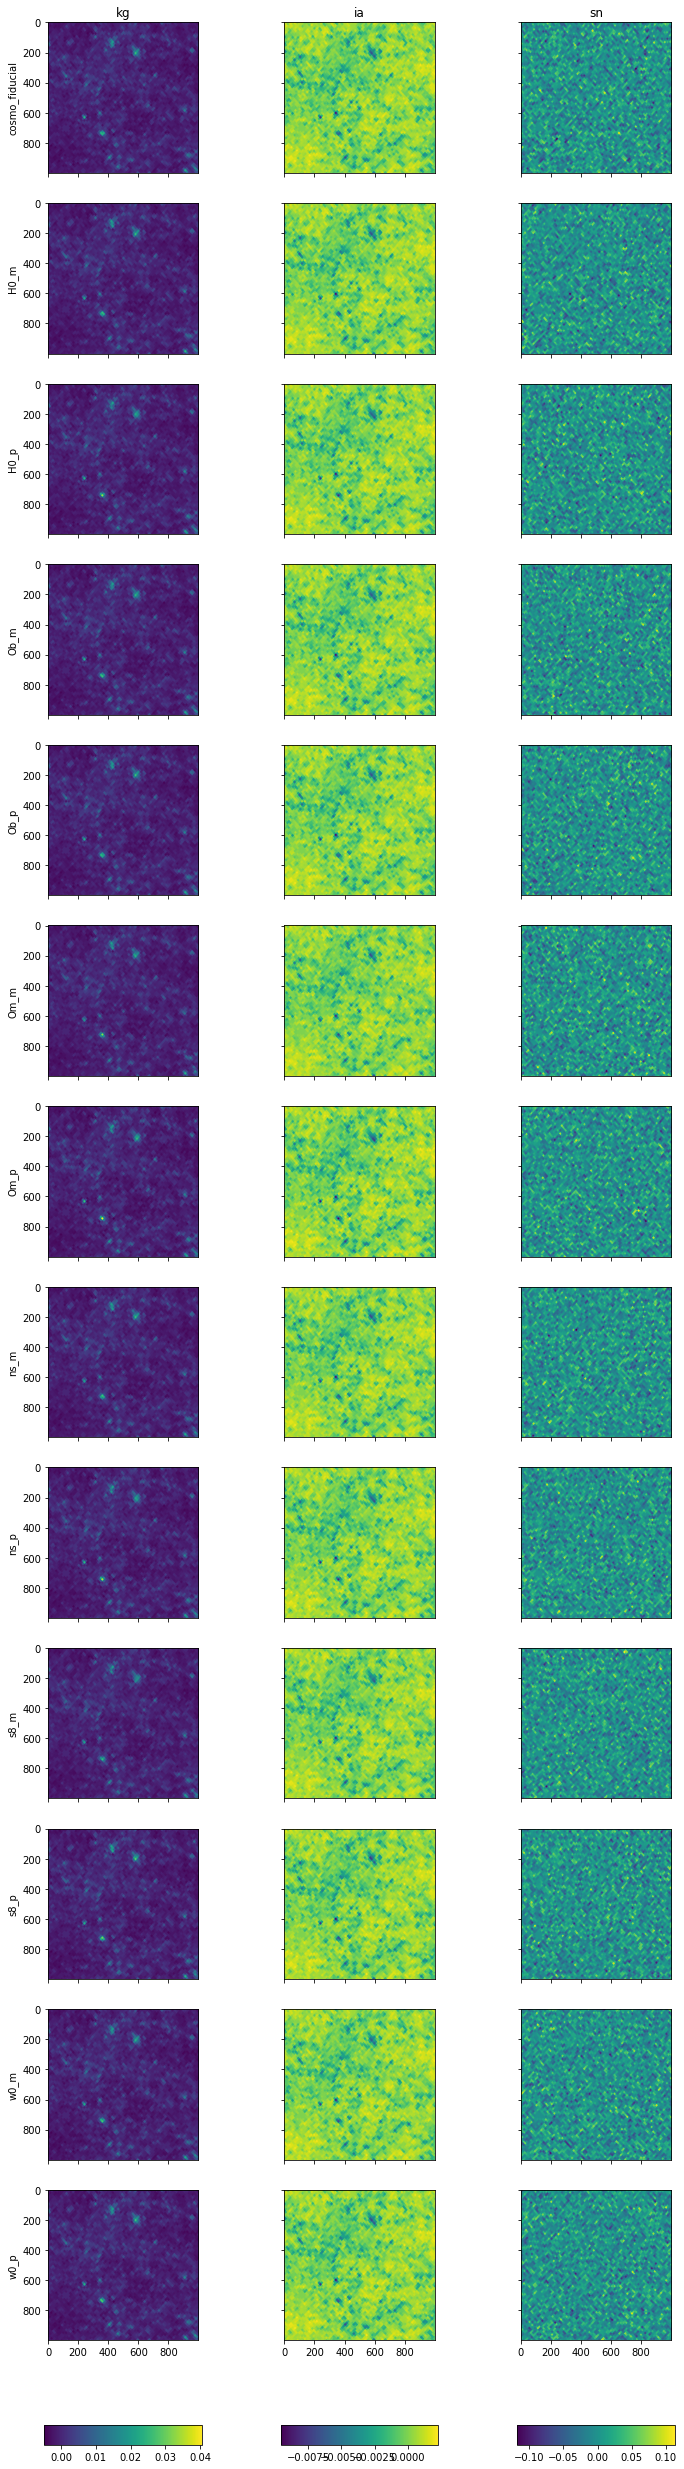

In [27]:
square_pix = 1000
reso = 0.5
tomo = 0
map_types = ["kg", "ia", "sn"]

counter = 0
for element in dataset.take(1):
    n_map_types = len(element)
    n_perts = len(element[0])
    
    fig, ax = plt.subplots(figsize=(4*n_map_types, 4*n_perts), nrows=n_perts, ncols=n_map_types, sharex=True, sharey=True)
    ic(ax.shape)

    # different map types, kg, ia, sn
    for i, perts in enumerate(element):
        # different perturbations
        gnoms = []
        for pert in perts:
            hp_map = np.full(n_pix, hp.UNSEEN)
            hp_map[data_vec_pix] = pert[:, tomo]

            gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, return_projected_map=True, no_plot=True, xsize=square_pix, ysize=square_pix)
            gnoms.append(gnom)
        
        vmin = np.array(gnoms).min()
        vmax = np.array(gnoms).max()
        for j, gnom in enumerate(gnoms):
            im = ax[j,i].imshow(gnom, vmin=vmin, vmax=vmax)

            if i == 0:
                ax[j,i].set(ylabel=params_dir[j].replace("cosmo_delta_", "").replace("/", ""))
            if j == 0:
                ax[j,i].set(title=map_types[i])

            if j==(n_perts-1):
                fig.colorbar(im, ax=ax[:,i], orientation="horizontal", shrink=0.8, aspect=8, pad=0.03)
    counter += 1
                
    fig.savefig(f"fiducial_perturbations_{counter}", dpi=300, bbox_inches='tight')

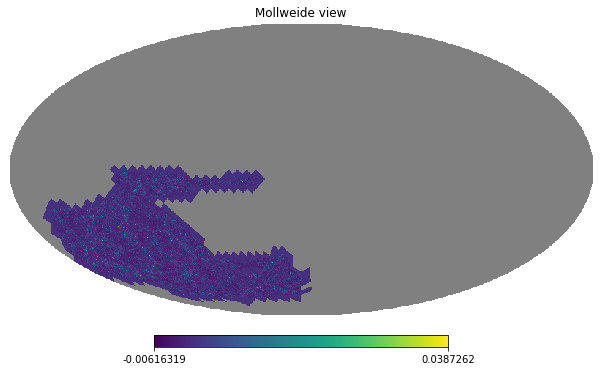

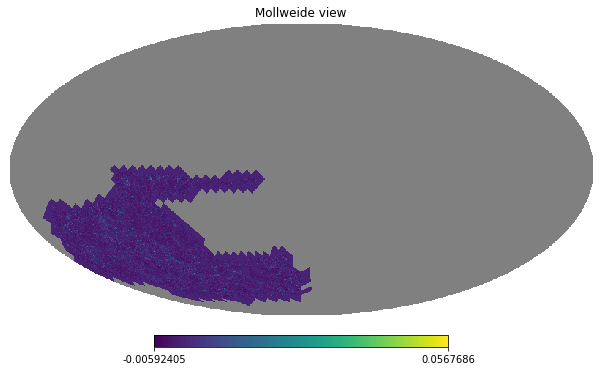

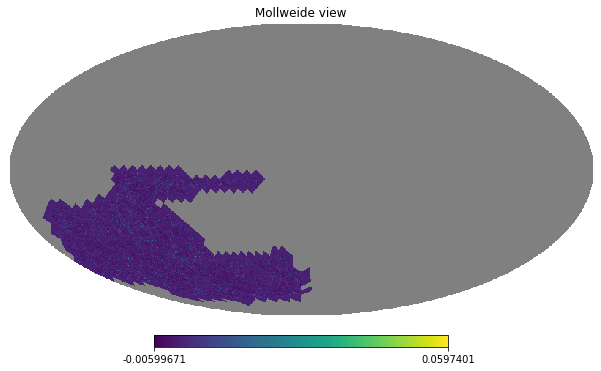

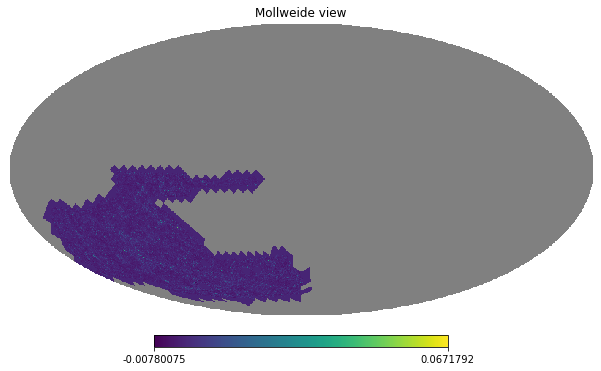

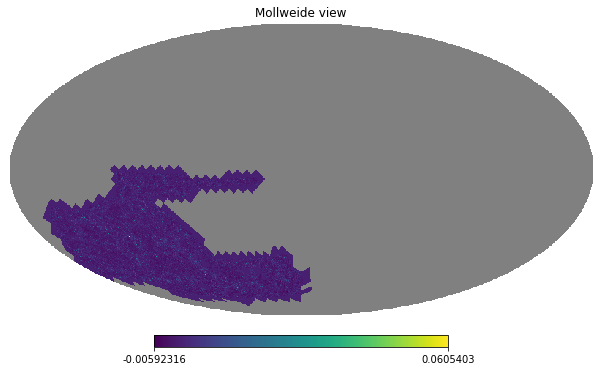

In [19]:
for kg, ia, sn in dataset.take(5):
    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = kg[0,:,0]

    hp.mollview(hp_map, nest=True)